# Linear Regression with Statsmodels for Movie Revenue

- 09/06/22

## Activity: Create a Linear Regression Model with Statsmodels for Revenue

- Today we will be working with JUST the data data from the TMDB API for years 2000-2021. 
    - We will prepare the data for modeling
        - Some feature engineering
        - Our usual Preprocessing
        - New steps for statsmodels!
    - We will fit a statsmodels linear regression.
    - We Will inspect the model summary.
    - We will create the visualizations to check assumptions about the residuals.



- Next class we will continue this activity.
    - We will better check all 4 assumptions.
    - We will discuss tactics for dealing with violations of the assumptions. 
    - We will use our coefficients to make stakeholder recommendations.

### Concepts Demonstrated

- [ ] Using `glob` for loading in all final files. 
- [ ] Statsmodels OLS
- [ ] QQ-Plot
- [ ] Residual Plot

# Loading the Data

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
## fixing random for lesson generation
np.random.seed(321)

In [2]:
pd.set_option('display.max_columns',100)

### 📚 Finding & Loading Batches of Files with `glob`

In [3]:
## Checking what data we already have in our Data folder using os.listdir
import os
FOLDER = 'Data/'
file_list = sorted(os.listdir(FOLDER))
file_list

['.DS_Store',
 '2010-2021',
 'combined_tmdb_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2002.json',
 'tmdb_api_results_2003.json',
 'tmdb_api_results_2004.json',
 'tmdb_api_results_2005.json',
 'tmdb_api_results_2006.json',
 'tmdb_api_results_2007.json',
 'tmdb_api_results_2008.json',
 'tmdb_api_results_2009.json',
 'tmdb_api_results_2010.json',
 'tmdb_api_results_2011.json',
 'tmdb_api_results_2012.json',
 'tmdb_api_results_2013.json',
 'tmdb_api_results_2014.json',
 'tmdb_api_results_2015.json',
 'tmdb_api_results_2016.json',


In [5]:
## Try loading in the first .csv.gz file from the list
#pd.read_csv(file_list[5])#lineterminator='\n')

> Why isn't it working?

In [6]:
## let's check the filepath 
file_list[1]

'2010-2021'

In [7]:
## add the folder plus filename
FOLDER+ file_list[1]

'Data/2010-2021'

In [8]:
## try read csv with folder plus filename
pd.read_csv(FOLDER+ file_list[5])

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,109809.0,en,Crime and Punishment,A modern day adaptation of Dostoyevsky's class...,6.751,/2ckMQwDi11TofiNoaE3sHrYbaCh.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2002-06-01,0.0,126.0,"[{'english_name': 'Polish', 'iso_639_1': 'pl',...",Released,NaN,Crime and Punishment,0.0,5.5,11.0,NaN
2,tt0118926,0.0,/p3BzCgX1gDIPdWfuFqRHIe52Ynf.jpg,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,20689.0,en,The Dancer Upstairs,A police detective in a South American country...,8.968,/jG662jKzEf63fhcbbN3WiLlz5MX.jpg,"[{'id': 357, 'logo_path': None, 'name': 'Vía D...","[{'iso_3166_1': 'ES', 'name': 'Spain'}, {'iso_...",2002-09-20,5227348.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An honest man caught in a world of intrigue, p...",The Dancer Upstairs,0.0,6.3,50.0,R
3,tt0119980,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,563364.0,en,Random Shooting in LA,The seamy side of Los Angeles is revealed thro...,1.400,NaN,"[{'id': 111499, 'logo_path': None, 'name': 'Co...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-07-13,0.0,91.0,[],Released,NaN,Random Shooting in LA,0.0,0.0,0.0,NaN
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,NaN,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,"A biography of artist Frida Kahlo, who channel...",20.554,/a4hgR6aKoohB6MHni171jbi9BkU.jpg,"[{'id': 14, 'logo_path': '/m6AHu84oZQxvq7n1rsv...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",2002-08-29,56298474.0,123.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Prepare to be seduced.,Frida,0.0,7.5,1720.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,tt6449044,0.0,/a9pkw8stijESGx1flSGPqcXLkHu.jpg,"{'id': 957260, 'name': 'The Conman Collection'...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,314105.0,cn,賭俠2002,Ka-shing has lived his entire life as a luckle...,2.255,/2hOLi6bgnM2S4MRAznNg9rvlyRH.jpg,"[{'id': 97722, 'logo_path': None, 'name': 'The...","[{'iso_3166_1': 'HK', 'name': 'Hong Kong'}]",2002-11-07,0.0,97.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,The Conman 2002,0.0,6.0,2.0,NaN
1217,tt6694126,0.0,/sXjVpTZyDvwzPVZve3AmyCUBeHk.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,819174.0,fa,عروس خوش‌قدم,Donya is a wealthy woman but she is not living...,0.600,/5hh7PZ1wcjzmBycwFCEaM7gf2M3.jpg,[],[],2002-05-01,0.0,101.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,NaN,The Lucky Bride,0.0,0.0,0.0,NaN
1218,tt8302928,0.0,NaN,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,866533.0,el,Movie Toons: Treasure Island,NaN,0.600,/efRAGh5Bxs7jnQOgPlh3MCiyqli.jpg,"[{'id': 20477, 'logo_path': '/u0zjebYOFWdLcpR4...","[{'iso_3166_1': 'US', 'name': 'United States o...",2002-09-22,0.0,0.0,[],Released,NaN,Movie Toons: Treasure Island,0.0,0.0,0.0,NaN
1219,tt8474326,0.0,NaN,NaN,0.0,[],NaN,292027.0,en,Skin Eating Jungle Vampires,In the mysterious jungles of Costa Rica a youn...,0.600,/eEVg28143gxcaRssbbIq2lvYVec.jpg,[],[],2002-10-06,0.0,0.0,[],Released,NaN,Skin Eating Jungle Vampires,0.0,0.0,0.0,NaN


- Now we would do that in a loop, and only want to open .csv.gz.
- But there is a better way!
>- Introducing `glob`
    - Glob takes a filepath/query and will find every filename that matches the pattern provided.
    - We use asterisks as wildcards in our query.
    


In [9]:
import glob
## Make a filepath query
q = FOLDER+"final*.csv.gz"
q

'Data/final*.csv.gz'

In [10]:
# Use glob.glob to get COMPLETE filepaths
file_list = glob.glob(q)
file_list

['Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz']

In [12]:
pd.read_csv(file_list[0],lineterminator ='\n')

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,tt7503878,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,481010.0,fr,Vintage Erotica Anno 1920,19 remastered French short films from the 20'...,0.840,/iVmJ5s3bgHaqCaDTBQ6mh4cxqgx.jpg,[],"[{'iso_3166_1': 'FR', 'name': 'France'}]",2006-08-01,0.0,90.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,Vintage Erotica Anno 1920,0.0,9.0,1.0,NaN
1791,tt7775532,0.0,NaN,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",https://www.youtube.com/watch?v=_neakMwmoCY,939621.0,en,Neck of da Woodz,Five brothas run outta gas in the sticks and r...,0.600,/AgSO3MvqVbqKqBtQjWPmgAEteNW.jpg,"[{'id': 170026, 'logo_path': None, 'name': '2 ...",[],NaN,0.0,72.0,[],Released,Survival is all that matters when Boyz from th...,Neck of da Woodz,0.0,10.0,1.0,NaN
1792,tt8165062,0.0,NaN,"{'id': 800116, 'name': 'Survive Girls', 'poste...",0.0,"[{'id': 27, 'name': 'Horror'}]",NaN,800112.0,ja,Sabaibu,Experience two erotic tales of survival that w...,1.343,/8V80ADHG6UqpNwUWL8v7pAWnW3S.jpg,[],"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2010-10-26,0.0,86.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Survive Girls,0.0,0.0,0.0,NaN
1793,tt8784950,0.0,NaN,NaN,0.0,[],NaN,939503.0,zh,浅蓝深蓝,NaN,0.600,/baG7vzBr1yAwVHd7nYH1SmAFVBs.jpg,[],[],2006-01-31,0.0,0.0,[],Released,NaN,浅蓝深蓝,0.0,0.0,0.0,NaN


In [ ]:
# Use glob.glob to get COMPLETE filepaths


> But where are the rest of the years?

In [ ]:
## in a sub-folder


- Recursive Searching with glob.
    - add a `**/` in the middle of your query to grab any matches from all subfolders. 

In [13]:
# Use glob.glob to get COMPLETE filepaths
q = FOLDER+"**/final*.csv.gz"
file_list = glob.glob(q,recursive = True)
file_list

['Data/final_tmdb_data_2006.csv.gz',
 'Data/final_tmdb_data_2008.csv.gz',
 'Data/final_tmdb_data_2004.csv.gz',
 'Data/final_tmdb_data_2000.csv.gz',
 'Data/final_tmdb_data_2002.csv.gz',
 'Data/final_tmdb_data_2007.csv.gz',
 'Data/final_tmdb_data_2009.csv.gz',
 'Data/final_tmdb_data_2005.csv.gz',
 'Data/final_tmdb_data_2001.csv.gz',
 'Data/final_tmdb_data_2003.csv.gz',
 'Data/2010-2021/final_tmdb_data_2018.csv.gz',
 'Data/2010-2021/final_tmdb_data_2014.csv.gz',
 'Data/2010-2021/final_tmdb_data_2016.csv.gz',
 'Data/2010-2021/final_tmdb_data_2020.csv.gz',
 'Data/2010-2021/final_tmdb_data_2012.csv.gz',
 'Data/2010-2021/final_tmdb_data_2010.csv.gz',
 'Data/2010-2021/final_tmdb_data_2019.csv.gz',
 'Data/2010-2021/final_tmdb_data_2015.csv.gz',
 'Data/2010-2021/final_tmdb_data_2021.csv.gz',
 'Data/2010-2021/final_tmdb_data_2017.csv.gz',
 'Data/2010-2021/final_tmdb_data_2013.csv.gz',
 'Data/2010-2021/final_tmdb_data_2011.csv.gz']

In [14]:
df_list =[]
for file in file_list:
    temp_df = pd.read_csv(file,lineterminator='\n')
    df_list.append(temp_df)
len(df_list)

22

In [15]:
pd.concat(df_list)

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,North point,0.0,0.0,0.0,NaN


In [16]:
# ## use a list comprehension to load in all files into 1 dataframe
df = pd.concat([pd.read_csv(file,lineterminator='\n') for file in file_list])
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,North point,0.0,0.0,0.0,NaN


- Dealing with ParserErrors with "possibly malformed files"

    - for a reason I do not fully understand yet, some of the files I downloaded error if I try to read them.
        - "ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.`
    - After some googling, the fix was to add `lineterminator='\n'` to pd.read_csv


In [17]:
# remove ids that are 0  and then reset index
df = df.loc[df['imdb_id']!='0']
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
1,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
2,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
3,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
4,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
5,tt0244521,0.0,/4W53mm2nvOtiOuPNW2oiBm9pmUZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9925.0,en,Funny Money,"Henry Perkins, a mild-mannered accountant, acc...",5.591,/oG3jWUZiDqqrdk3oKwPEkuwoN89.jpg,"[{'id': 110622, 'logo_path': None, 'name': 'FW...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2006-01-01,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Henry Perkins accidentally trades briefcases w...,Funny Money,0.0,5.4,39.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
2894,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
2895,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
2896,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,Nort

In [18]:
df = df.reset_index(drop=True)
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
1,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
2,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
3,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
4,tt0244521,0.0,/4W53mm2nvOtiOuPNW2oiBm9pmUZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9925.0,en,Funny Money,"Henry Perkins, a mild-mannered accountant, acc...",5.591,/oG3jWUZiDqqrdk3oKwPEkuwoN89.jpg,"[{'id': 110622, 'logo_path': None, 'name': 'FW...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2006-01-01,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Henry Perkins accidentally trades briefcases w...,Funny Money,0.0,5.4,39.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
60126,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
60127,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
60128,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,

In [19]:
## saving the combined csv to disk
df.to_csv('Data/combined_tmdb_data.csv.gz',compression= "gzip",index = False)

In [20]:
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0144280,0.0,NaN,NaN,100000.0,[],NaN,30356.0,en,Whispers from a Shallow Grave,"When a beautiful photo model disappears, polic...",1.176,/cjRqAh3u2Z0MBx9GtT1k7Z9732w.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",1997-01-01,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Whispers from a Shallow Grave,0.0,2.0,2.0,NaN
1,tt0197633,0.0,/1hGrzTajJ5JC6VfPzrUj8Gj5t5k.jpg,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,58520.0,en,Live Freaky Die Freaky,It is the year 3069 and the Earth has been rob...,3.131,/3QKPZ9SzMcBdqkKdSitQbmRqB2l.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2006-01-31,0.0,75.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Live Freaky Die Freaky,0.0,3.8,8.0,NR
2,tt0204250,0.0,/qKiOZMJH9Riqlk2SkUOgSMZHHJu.jpg,NaN,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",NaN,459563.0,en,Death of a Saleswoman,Top-ranking RubberTubber saleswoman Agatha J. ...,0.600,/tIfllOpkhZl5sbqZd1X77iiaJDj.jpg,"[{'id': 90905, 'logo_path': None, 'name': 'Gir...","[{'iso_3166_1': 'US', 'name': 'United States o...",2006-09-18,0.0,77.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,6 housewives. 1 dead body. A trunk full of pla...,Death of a Saleswoman,0.0,3.0,1.0,NaN
3,tt0206634,0.0,/z8FzomPxfCb2nv827VWLSI6oYiB.jpg,NaN,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://www.universalstudiosentertainment.com/c...,9693.0,en,Children of Men,"In 2027, in a chaotic world in which humans ca...",19.318,/k9IAS4TehZFcKi4HVByxZNPfqex.jpg,"[{'id': 33, 'logo_path': '/8lvHyhjr8oUKOOy2dKX...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2006-09-22,70595464.0,109.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The future's a thing of the past.,Children of Men,0.0,7.6,5779.0,R
4,tt0244521,0.0,/4W53mm2nvOtiOuPNW2oiBm9pmUZ.jpg,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,9925.0,en,Funny Money,"Henry Perkins, a mild-mannered accountant, acc...",5.591,/oG3jWUZiDqqrdk3oKwPEkuwoN89.jpg,"[{'id': 110622, 'logo_path': None, 'name': 'FW...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2006-01-01,0.0,98.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Henry Perkins accidentally trades briefcases w...,Funny Money,0.0,5.4,39.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,490059.0,ko,도약선생,Won-sik is kicked out by her roommate Woo-jung...,0.914,/rXrDkS3Mpow9q915zrmiH3stAn5.jpg,[],"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2011-06-30,0.0,65.0,"[{'english_name': 'Korean', 'iso_639_1': 'ko',...",Released,NaN,Dr. Jump,0.0,7.0,1.0,NaN
60126,tt9385434,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,566831.0,ja,お米とおっぱい。,"What would you choose, between rice and boobs,...",1.400,/4cmlMKKDkbCxm2Kjs4gfmTFL7XE.jpg,"[{'id': 11725, 'logo_path': '/3OZxd70DZ1LbVelm...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2011-07-01,0.0,102.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,NaN,Rice and Boobs,0.0,0.0,0.0,NaN
60127,tt9452878,0.0,NaN,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,108925.0,en,The Wrong Ferarri,The Wrong Ferarri is a feature-film written an...,1.884,NaN,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-04-04,0.0,72.0,[],Released,NaN,The Wrong Ferarri,0.0,2.0,1.0,NaN
60128,tt9519786,0.0,/oof2qSqrH1PAe9yEaBnId1P326G.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,874426.0,zh,North point,NaN,1.343,/ynnOmcXSIQlWnCykRWA3o0rPsAv.jpg,"[{'id': 158558, 'logo_path': None, 'name': '上海...",[],2011-11-04,0.0,0.0,[],Released,NaN,

# Preprocessing

In [22]:
## Columns to exclude
drop_cols = ['backdrop_path','backdrop_path','original_title','overview',
                 'poster_path','status','tagline','id','homepage',
                 'production_countries','video','production_companies','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

KeyError: "['backdrop_path', 'backdrop_path', 'original_title', 'overview', 'poster_path', 'status', 'tagline', 'id', 'homepage', 'production_countries', 'video', 'production_companies', 'spoken_languages', 'original_language'] not found in axis"

## Feature Engineering


- belongs to collection: convert to boolean
- Genres: get just name and manually OHE
- Cleaning Categories in Certification
- Converting release date to year, month, and day.

### belongs to collection

In [23]:
# there are 3,700+ movies that belong to collections
df['belongs_to_collection'].notna().sum()

3738

In [24]:
## Use .notna() to get True if it belongs to a collection
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    56392
True      3738
Name: belongs_to_collection, dtype: int64

### genre

In [25]:
df.loc[3,'genres']

"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}, {'id': 878, 'name': 'Science Fiction'}]"

In [26]:
## Function to get just the genre names as a list 
import json
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [27]:
## Use our function and exploding the new column


# use get_genre_name and convert all the genere name in list

df['genre_list']= df['genres'].apply(get_genre_name)

df_explode = df.explode('genre_list')
df_explode

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list
0,tt0144280,0.0,False,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,NaN
1,tt0197633,0.0,False,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Animation
1,tt0197633,0.0,False,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Comedy
1,tt0197633,0.0,False,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Music
1,tt0197633,0.0,False,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,Science Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60127,tt9452878,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,Drama
60127,tt9452878,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,Music
60128,tt9519786,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,Drama
60129,tt9547900,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",1.343,2011-05-13,0.0,0.0,百年情书,0.0,0.0,NaN,Drama


In [28]:
## save unique genres
#unique_genres = df_explode['genre_list'].unique()
unique_genres = df_explode['genre_list'].dropna().unique()
unique_genres

array(['Animation', 'Comedy', 'Music', 'Science Fiction', 'Mystery',
       'Drama', 'Action', 'Thriller', 'Crime', 'Romance', 'Horror',
       'Adventure', 'Family', 'Fantasy', 'History', 'Documentary', 'War',
       'Western', 'TV Movie'], dtype=object)

In [29]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex =False)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,genre_list,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
0,tt0144280,0.0,False,100000.0,[],1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,[],False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0197633,0.0,False,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,"[Animation, Comedy, Music, Science Fiction]",True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0204250,0.0,False,0.0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 35, '...",0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,"[Mystery, Comedy]",False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0206634,0.0,False,76000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,"[Drama, Action, Thriller, Science Fiction]",False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0244521,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,"[Comedy, Crime]",False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}]",0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN,[Comedy],False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt9385434,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN,[Drama],False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt9452878,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,"[Comedy, Drama, Music]",False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9519786,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,[Drama],False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


In [30]:
## Drop original genre cols
df  = df.drop(columns=['genres','genre_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
0,tt0144280,0.0,False,100000.0,1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,tt0197633,0.0,False,0.0,3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,tt0204250,0.0,False,0.0,0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,tt0206634,0.0,False,76000000.0,19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False
4,tt0244521,0.0,False,0.0,5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,False,0.0,0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
60126,tt9385434,0.0,False,0.0,1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60127,tt9452878,0.0,False,0.0,1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
60128,tt9519786,0.0,False,0.0,1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False


### certification

In [31]:
## Checking Certification values counts
df['certification'].value_counts(dropna = False)

NaN                                45506
R                                   6097
NR                                  3261
PG-13                               3224
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
ScreamFest Horror Film Festival        1
UR                                     1
Not Rated                              1
-                                      1
PG-13                                  1
10                                     1
R                                      1
Name: certification, dtype: int64

In [32]:
# fix extra space certs
df['certification'] = df['certification'].str.strip()
df['certification'].value_counts(dropna = False)

NaN                                45506
R                                   6098
NR                                  3261
PG-13                               3225
PG                                  1432
G                                    442
NC-17                                156
Unrated                                5
ScreamFest Horror Film Festival        1
UR                                     1
Not Rated                              1
-                                      1
10                                     1
Name: certification, dtype: int64

In [33]:
## fix certification col
repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'].value_counts(dropna=False)

NaN      45507
R         6098
NR        3270
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

### Converting year to sep features

In [34]:
## split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] =df[new_cols].astype(float)
df

,imdb_id,adult,belongs_to_collection,budget,popularity,release_date,revenue,runtime,title,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day
0,tt0144280,0.0,False,100000.0,1.176,1997-01-01,0.0,90.0,Whispers from a Shallow Grave,2.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1997.0,1.0,1.0
1,tt0197633,0.0,False,0.0,3.131,2006-01-31,0.0,75.0,Live Freaky Die Freaky,3.8,8.0,NR,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,31.0
2,tt0204250,0.0,False,0.0,0.600,2006-09-18,0.0,77.0,Death of a Saleswoman,3.0,1.0,NaN,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,18.0
3,tt0206634,0.0,False,76000000.0,19.318,2006-09-22,70595464.0,109.0,Children of Men,7.6,5779.0,R,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,22.0
4,tt0244521,0.0,False,0.0,5.591,2006-01-01,0.0,98.0,Funny Money,5.4,39.0,R,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9282946,0.0,False,0.0,0.914,2011-06-30,0.0,65.0,Dr. Jump,7.0,1.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,6.0,30.0
60126,tt9385434,0.0,False,0.0,1.400,2011-07-01,0.0,102.0,Rice and Boobs,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,7.0,1.0
60127,tt9452878,0.0,False,0.0,1.884,2011-04-04,0.0,72.0,The Wrong Ferarri,2.0,1.0,NaN,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,4.0,4.0
60128,tt9519786,0.0,False,0.0,1.343,2011-11-04,0.0,0.0,North point,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,11.0,4.0


In [35]:
## drop original feature
df = df.drop(columns=['release_date'])

## Train Test Split

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   belongs_to_collection  60130 non-null  bool   
 3   budget                 60130 non-null  float64
 4   popularity             60130 non-null  float64
 5   revenue                60130 non-null  float64
 6   runtime                59298 non-null  float64
 7   title                  60130 non-null  object 
 8   vote_average           60130 non-null  float64
 9   vote_count             60130 non-null  float64
 10  certification          14623 non-null  object 
 11  Genre_Animation        60130 non-null  bool   
 12  Genre_Comedy           60130 non-null  bool   
 13  Genre_Music            60130 non-null  bool   
 14  Genre_Science Fiction  60130 non-null  bool   
 15  Ge

In [37]:
drop_for_model = ['title','imdb_id']
df.drop(columns=drop_for_model)

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day
0,0.0,False,100000.0,1.176,0.0,90.0,2.0,2.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1997.0,1.0,1.0
1,0.0,False,0.0,3.131,0.0,75.0,3.8,8.0,NR,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,31.0
2,0.0,False,0.0,0.600,0.0,77.0,3.0,1.0,NaN,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,18.0
3,0.0,False,76000000.0,19.318,70595464.0,109.0,7.6,5779.0,R,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,2006.0,9.0,22.0
4,0.0,False,0.0,5.591,0.0,98.0,5.4,39.0,R,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,2006.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,0.0,False,0.0,0.914,0.0,65.0,7.0,1.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,6.0,30.0
60126,0.0,False,0.0,1.400,0.0,102.0,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,7.0,1.0
60127,0.0,False,0.0,1.884,0.0,72.0,2.0,1.0,NaN,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,4.0,4.0
60128,0.0,False,0.0,1.343,0.0,0.0,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2011.0,11.0,4.0


In [38]:
## Make x and y variables

y = df['revenue'].copy()
X = df.drop(columns=['revenue',*drop_for_model]).copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)#, random_state=321)
X_train.head()

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,year,month,day
9538,0.0,False,0.0,0.600,70.0,0.0,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2007.0,10.0,24.0
16553,0.0,False,0.0,9.087,100.0,6.1,141.0,NaN,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2018.0,12.0,7.0
34106,0.0,False,10.0,1.842,89.0,4.5,4.0,NaN,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2012.0,3.0,18.0
3804,0.0,False,0.0,1.092,97.0,0.0,0.0,NaN,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2008.0,8.0,7.0
37747,0.0,False,0.0,1.209,98.0,2.8,8.0,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2019.0,7.0,12.0


In [39]:
X_train.isna().sum()

adult                        0
belongs_to_collection        0
budget                       0
popularity                   0
runtime                    626
vote_average                 0
vote_count                   0
certification            34093
Genre_Animation              0
Genre_Comedy                 0
Genre_Music                  0
Genre_Science Fiction        0
Genre_Mystery                0
Genre_Drama                  0
Genre_Action                 0
Genre_Thriller               0
Genre_Crime                  0
Genre_Romance                0
Genre_Horror                 0
Genre_Adventure              0
Genre_Family                 0
Genre_Fantasy                0
Genre_History                0
Genre_Documentary            0
Genre_War                    0
Genre_Western                0
Genre_TV Movie               0
year                       760
month                      760
day                        760
dtype: int64

In [40]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [41]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Animation',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Science Fiction',
 'Genre_Mystery',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Thriller',
 'Genre_Crime',
 'Genre_Romance',
 'Genre_Horror',
 'Genre_Adventure',
 'Genre_Family',
 'Genre_Fantasy',
 'Genre_History',
 'Genre_Documentary',
 'Genre_War',
 'Genre_Western',
 'Genre_TV Movie']

In [42]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [43]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [44]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),#StandardScaler()
                        )

preprocessor = make_column_transformer((cat_pipe,cat_cols),
                                        (num_pipe, num_cols),
                                       ('passthrough',already_ohe_cols))# remainder='passthrough')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', '...
                                ('passthrough', 'passthrough',
                                 ['belongs_to_collection', 'Genre_Animation',
                                  'Genre_Comedy', 'Genre_Music',
                                  'Genre_Science Fiction', 'Genre_Mystery',
                                  'Genre_Drama', 'Genre_Action',
                                  'Genre_Thriller', 'Genre_Crime',
                                  'Genre_Romance', 'Genre_Horror',
                                  'Genre_Adventure', 'Genre_Family',
                                  'Genre_Fantasy', 'Genre_History',
                                  'Genre_Documentary', 'Genre_War',
                                  'Genre_Western', 'Genre_TV Movie'])])

In [45]:
## fit the col transformer
preprocessor.fit(X_train)

## Finding the categorical pipeline in our col transformer.
preprocessor.named_transformers_['pipeline-1']

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [46]:
## B) Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-1'][-1].get_feature_names_out(cat_cols)

## Create the empty list
final_features = [*cat_features,*num_cols,*already_ohe_cols]
len(final_features)

36

In [47]:
## checking shape matches len final features
preprocessor.transform(X_train).shape

(45097, 36)

In [48]:
## make X_train_tf 
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
9538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600,70.0,0.0,0.0,2007.0,10.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.087,100.0,6.1,141.0,2018.0,12.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34106,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.842,89.0,4.5,4.0,2012.0,3.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3804,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.092,97.0,0.0,0.0,2008.0,8.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37747,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.209,98.0,2.8,8.0,2019.0,7.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
## make X_test_tf 

X_test_tf = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)
X_test_tf.head()

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie
19252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911,90.0,4.5,2.0,2018.0,2.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.911,148.0,5.1,19.0,2019.0,1.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35595,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.728,78.0,5.4,4.0,2010.0,9.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
979,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.719,97.0,6.1,21.0,2006.0,2.0,24.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44055,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.549,160.0,6.8,124.0,2015.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Adding a Constant for Statsmodels

In [50]:
##import statsmodels correctly
import statsmodels.api as sm

> Tip: make sure that add_constant actually added a new column! You may need to change the parameter `has_constant` to "add"

In [51]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False)
X_test_df = sm.add_constant(X_test_tf, prepend=False)
display(X_train_df.head(2),X_test_df.head(2))

,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,const
9538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600,70.0,0.0,0.0,2007.0,10.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
16553,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.087,100.0,6.1,141.0,2018.0,12.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,certification_G,certification_MISSING,certification_NC-17,certification_NR,certification_PG,certification_PG-13,certification_R,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,belongs_to_collection,Genre_Animation,Genre_Comedy,Genre_Music,Genre_Science Fiction,Genre_Mystery,Genre_Drama,Genre_Action,Genre_Thriller,Genre_Crime,Genre_Romance,Genre_Horror,Genre_Adventure,Genre_Family,Genre_Fantasy,Genre_History,Genre_Documentary,Genre_War,Genre_Western,Genre_TV Movie,const
19252,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911,90.0,4.5,2.0,2018.0,2.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
40663,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.911,148.0,5.1,19.0,2019.0,1.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling

## Statsmodels OLS

In [52]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     3939.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:01:57   Log-Likelihood:            -8.4104e+05
No. Observations:               45097   AIC:                         1.682e+06
Df Residuals:                   45061   BIC:                         1.682e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
certification_G       -4.047e+06   6.64e+06     -0.609      0.542   -1.71e+07    8.97e+06
certification_MISSING -3.265e+06   6.52e+06     -0.501      0.616    -1.6e+07    9.51e+06
certification_NC-17   -9.406e+06   6.95e+06     -1.353      0.176    -2.3e+07    4.22e+06
certification_NR      -4.305e+06   6.55e+06     -0.658      0.511   -1.71e+07    8.53e+06
certification_PG      -3.792e+06   6.53e+06     -0.581      0.562   -1.66e+07    9.01e+06
certification_PG-13   -1.416e+07   6.49e+06     -2.181      0.029   -2.69e+07   -1.43e+06
certification_R        -1.72e+07   6.46e+06     -2.662      0.008   -2.99e+07   -4.54e+06
adult                  2.307e+06   3.66e+06      0.630      0.529   -4.87e+06    9.48e+06
budget                    1.6290      0.014    117.762      0.000       1.602       1.656
popularity             1.413e+05   4374.434     32.294      0.000    1.33e+05     1.5e+05
runtime               -7996.9801   5118.052     -1.563      0.118    -1.8e+04    2034.486
vote_average          -4.922e+05   5.93e+04     -8.301      0.000   -6.08e+05   -3.76e+05
vote_count             2.784e+04    198.084    140.535      0.000    2.74e+04    2.82e+04
year                   3.096e+04   2.57e+04      1.203      0.229   -1.95e+04    8.14e+04
month                 -8.737e+04   4.09e+04     -2.135      0.033   -1.68e+05   -7142.514
day                   -1.448e+04   1.58e+04     -0.917      0.359   -4.54e+04    1.65e+04
belongs_to_collection   1.11e+07   6.44e+05     17.249      0.000    9.84e+06    1.24e+07
Genre_Animation        1.349e+06   8.94e+05      1.509      0.131   -4.04e+05     3.1e+06
Genre_Comedy          -2.762e+05   3.53e+05     -0.783      0.434   -9.68e+05    4.15e+05
Genre_Music            7.879e+05   1.04e+06      0.761      0.447   -1.24e+06    2.82e+06
Genre_Science Fiction -4.257e+06   6.58e+05     -6.468      0.000   -5.55e+06   -2.97e+06
Genre_Mystery         -1.729e+06   6.76e+05     -2.557      0.011   -3.05e+06   -4.04e+05
Genre_Drama           -1.646e+05   3.29e+05     -0.501      0.616   -8.09e+05     4.8e+05
Genre_Action          -1.505e+06   4.92e+05     -3.059      0.002   -2.47e+06   -5.41e+05
Genre_Thriller        -1.704e+06    4.2e+05     -4.062      0.000   -2.53e+06   -8.82e+05
Genre_Crime           -2.652e+06   5.74e+05     -4.621      0.000   -3.78e+06   -1.53e+06
Genre_Romance         -2.026e+05   4.46e+05     -0.455      0.649   -1.08e+06    6.71e+05
Genre_Horror           2.477e+05   4.47e+05      0.555      0.579   -6.27e+05    1.12e+06
Genre_Adventure        2.319e+06   7.29e+05      3.183      0.001    8.91e+05    3.75e+06
Genre_Family          -6.977e+05   7.22e+05     -0.966      0.334   -2.11e+06    7.18e+05
Genre_Fantasy         -7.539e+05   7.18e+05     -1.050      0.294   -2.16e+06    6.53e+05
Genre_History         -

In [53]:
## Get train data performance from skearn to confirm matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.754
Testing R^2: 0.759


# The Assumptions of Linear Regression

- The 4 Assumptions of a Linear Regression are:
    - Linearity: That the input features have a linear relationship with the target.
    - Independence of features (AKA Little-to-No Multicollinearity): That the features are not strongly related to other features.
    - **Normality: The model's residuals are approximately normally distributed.**
    - **Homoscedasticity: The model residuals have equal variance across all predictions.**


### QQ-Plot for Checking for Normality

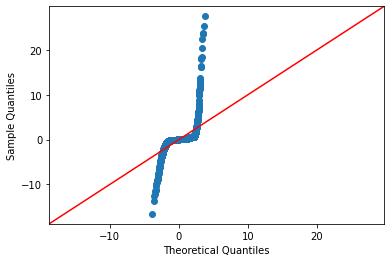

In [54]:
## Create a Q-QPlot

# first calculate residuals 
resid = y_test - y_hat_test

## then use sm's qqplot
fig, ax = plt.subplots(figsize=(6,4))
sm.graphics.qqplot(resid,line='45',fit=True,ax=ax);

### Residual Plot for Checking Homoscedasticity

[Text(0, 0.5, 'Residuals'), Text(0.5, 0, 'Predicted Revenue')]

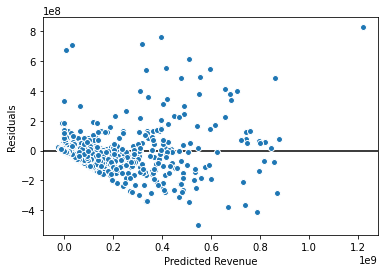

In [55]:
## Plot scatterplot with y_hat_test vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(y_hat_test, resid, ec='white')
ax.axhline(0,c='black',zorder=0)
ax.set(ylabel='Residuals',xlabel='Predicted Revenue')

### Putting it all together

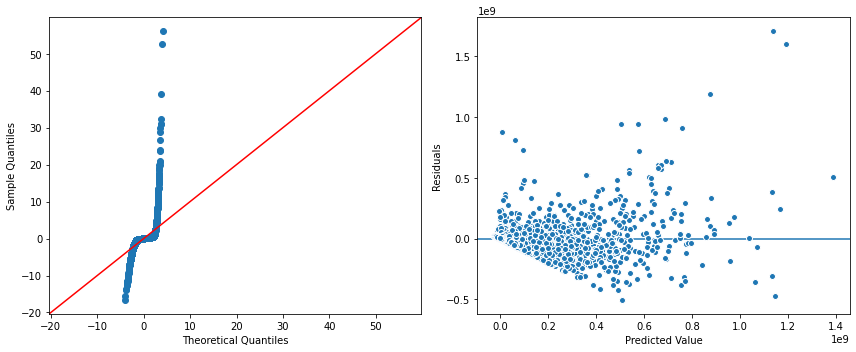

In [56]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()
    
evaluate_ols(result,X_train_df, y_train)



> Next class: iterating on our model & interpreting coefficients